In [1]:
import pandas as pd
import numpy as np
from calendar import day_name
import matplotlib.pyplot as plt
import pickle

from Utilities import plots
from Utilities import processing

# Preprocessing

## Old data

In [24]:
%%time
folder=r'Datasets/data.zip'
data = pd.read_csv(folder, parse_dates=['date'], encoding='utf-8')
data['weekday'] = data['date'].dt.weekday
data['day_name'] = data['date'].dt.day_name()
data

Wall time: 593 ms


,date,days,places,price,num,class,train,departure_hour,arrival_hour,places_frac,weekday,day_name
0,2021-04-12,1,28.0,3790.0,001А,Купе,001А-Купе,23.916667,7.916667,0.200000,0,Monday
1,2021-04-13,1,52.0,3790.0,001А,Купе,001А-Купе,23.916667,7.916667,0.371429,1,Tuesday
2,2021-04-14,1,91.0,2510.0,001А,Купе,001А-Купе,23.916667,7.916667,0.650000,2,Wednesday
3,2021-04-15,1,73.0,2510.0,001А,Купе,001А-Купе,23.916667,7.916667,0.521429,3,Thursday
4,2021-04-16,1,48.0,2510.0,001А,Купе,001А-Купе,23.916667,7.916667,0.342857,4,Friday
...,...,...,...,...,...,...,...,...,...,...,...,...
413037,2021-07-16,89,368.0,3200.0,780А,C2,780А-C2,21.000000,0.583333,0.994595,4,Friday
413038,2021-07-17,89,361.0,2660.0,780А,C2,780А-C2,21.000000,0.583333,0.975676,5,Saturday
413039,2021-07-19,89,362.0,2800.0,780А,C2,780А-C2,21.000000,0.583333,0.978378,0,Monday
413040,2021-07-22,89,368.0,2660.0,780А,C2,780А-C2,21.000000,0.583333,0.994595,3,Thursday


### Demand and prices

In [25]:
uniq_train_num=data['num'].unique()
wk_days_mask=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
places = data.pivot_table(index=['num', 'day_name', 'date', 'class'], columns='days', values='places')
train_name='752А'
wk_day='Friday'
places.loc[train_name].loc[wk_day, :14].head()
print(data.date.min())
print(data.date.max())

2021-04-12 00:00:00
2021-07-23 00:00:00


In [4]:
with open(r'Experiments\Incremental Learning\Data\uniq_train_num.data', 'wb') as f:
    pickle.dump(uniq_train_num, f)
    
with open(r'Experiments\Incremental Learning\Data\wk_days_mask.data', 'wb') as f:
    pickle.dump(wk_days_mask, f)

In [26]:
%%time
demand=(places-places.shift(axis=1))
demand[demand<0.]=np.nan
demand=demand.drop(columns=1, axis=0)
prices = data.pivot_table(index=['num', 'day_name', 'date', 'class'], columns='days', values='price')
prices_cons=prices.copy()
prices=prices.drop(columns=1, axis=0)
demand.loc[train_name].loc[wk_day, :14].head()

Wall time: 387 ms


days                2     3     4     5     6    7     8     9    10   11  \
date       class                                                            
2021-04-16 B1      4.0   2.0   0.0   2.0   0.0  0.0   3.0   2.0  0.0  0.0   
           B2     16.0  16.0   4.0   0.0   0.0  2.0   2.0   0.0  2.0  0.0   
           C1      9.0   4.0   0.0   0.0   0.0  1.0   2.0   0.0  1.0  0.0   
           C2     79.0  49.0  33.0  22.0  19.0  5.0  21.0  22.0  9.0  2.0   
2021-04-23 B1      0.0   NaN   NaN   0.0   0.0  2.0   0.0   1.0  0.0  NaN   

days               12   13   14  
date       class                 
2021-04-16 B1     0.0  0.0  0.0  
           B2     0.0  1.0  2.0  
           C1     0.0  0.0  1.0  
           C2     8.0  5.0  9.0  
2021-04-23 B1     0.0  0.0  1.0

Wall time: 1.61 s


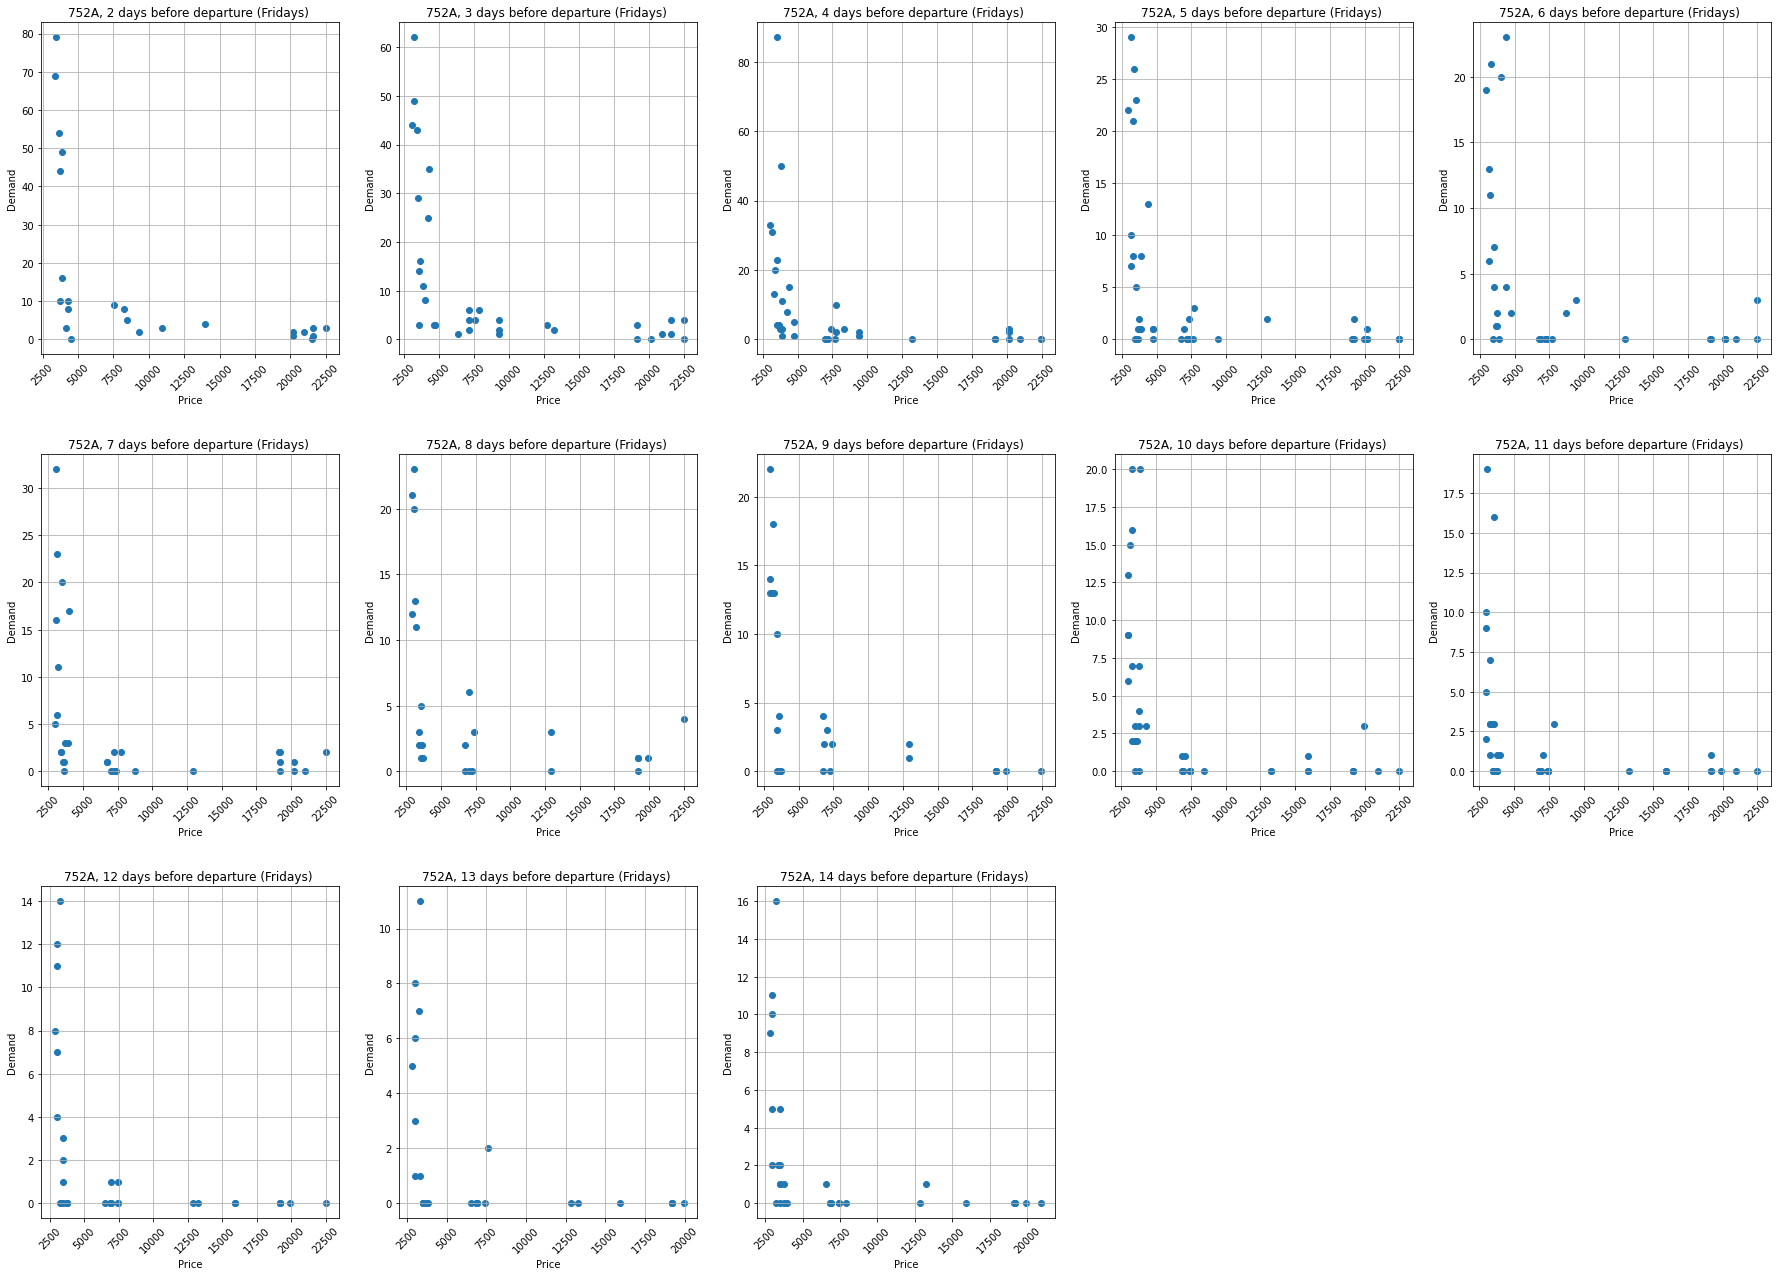

In [6]:
%%time
days=np.arange(2, 15)
folder='Experiments/Incremental Learning/Figure/'
plots.scatter_plot(prices.loc[train_name].loc[wk_day], demand.loc[train_name].loc[wk_day], days, train_name+' '+wk_day, 'original PED', save=True, folder=folder)

In [27]:
prices.to_csv('Experiments\Incremental Learning\Data\prices.csv')
demand.to_csv('Experiments\Incremental Learning\Data\demand.csv')
places.to_csv('Experiments\Incremental Learning\Data\places.csv')
prices_cons.to_csv('Experiments\Incremental Learning\Data\prices_cons.csv')

### Removing duplicates and averaging

In [8]:
%%time
mean_prices=pd.DataFrame(data=np.nan, columns=prices.columns, index=prices.index, dtype="float")
mean_demand=pd.DataFrame(data=np.nan, columns=demand.columns, index=demand.index, dtype="float")
for num in uniq_train_num:
    for wk_day in wk_days_mask:
        for day in demand.columns:
            pr_dem_piv=processing.mean_duplicate_prices(prices.loc[num].loc[wk_day][day], 
                                             demand.loc[num].loc[wk_day][day])
            
            flat_pr_dem_piv=processing.flat_grouped_classes(pr_dem_piv)
            
            mean_prices.loc[num, wk_day].T.loc[day]=flat_pr_dem_piv.set_index(['date', 'class'])['prices']
            mean_demand.loc[num, wk_day].T.loc[day]=flat_pr_dem_piv.set_index(['date', 'class'])['demand']

Wall time: 8min 12s


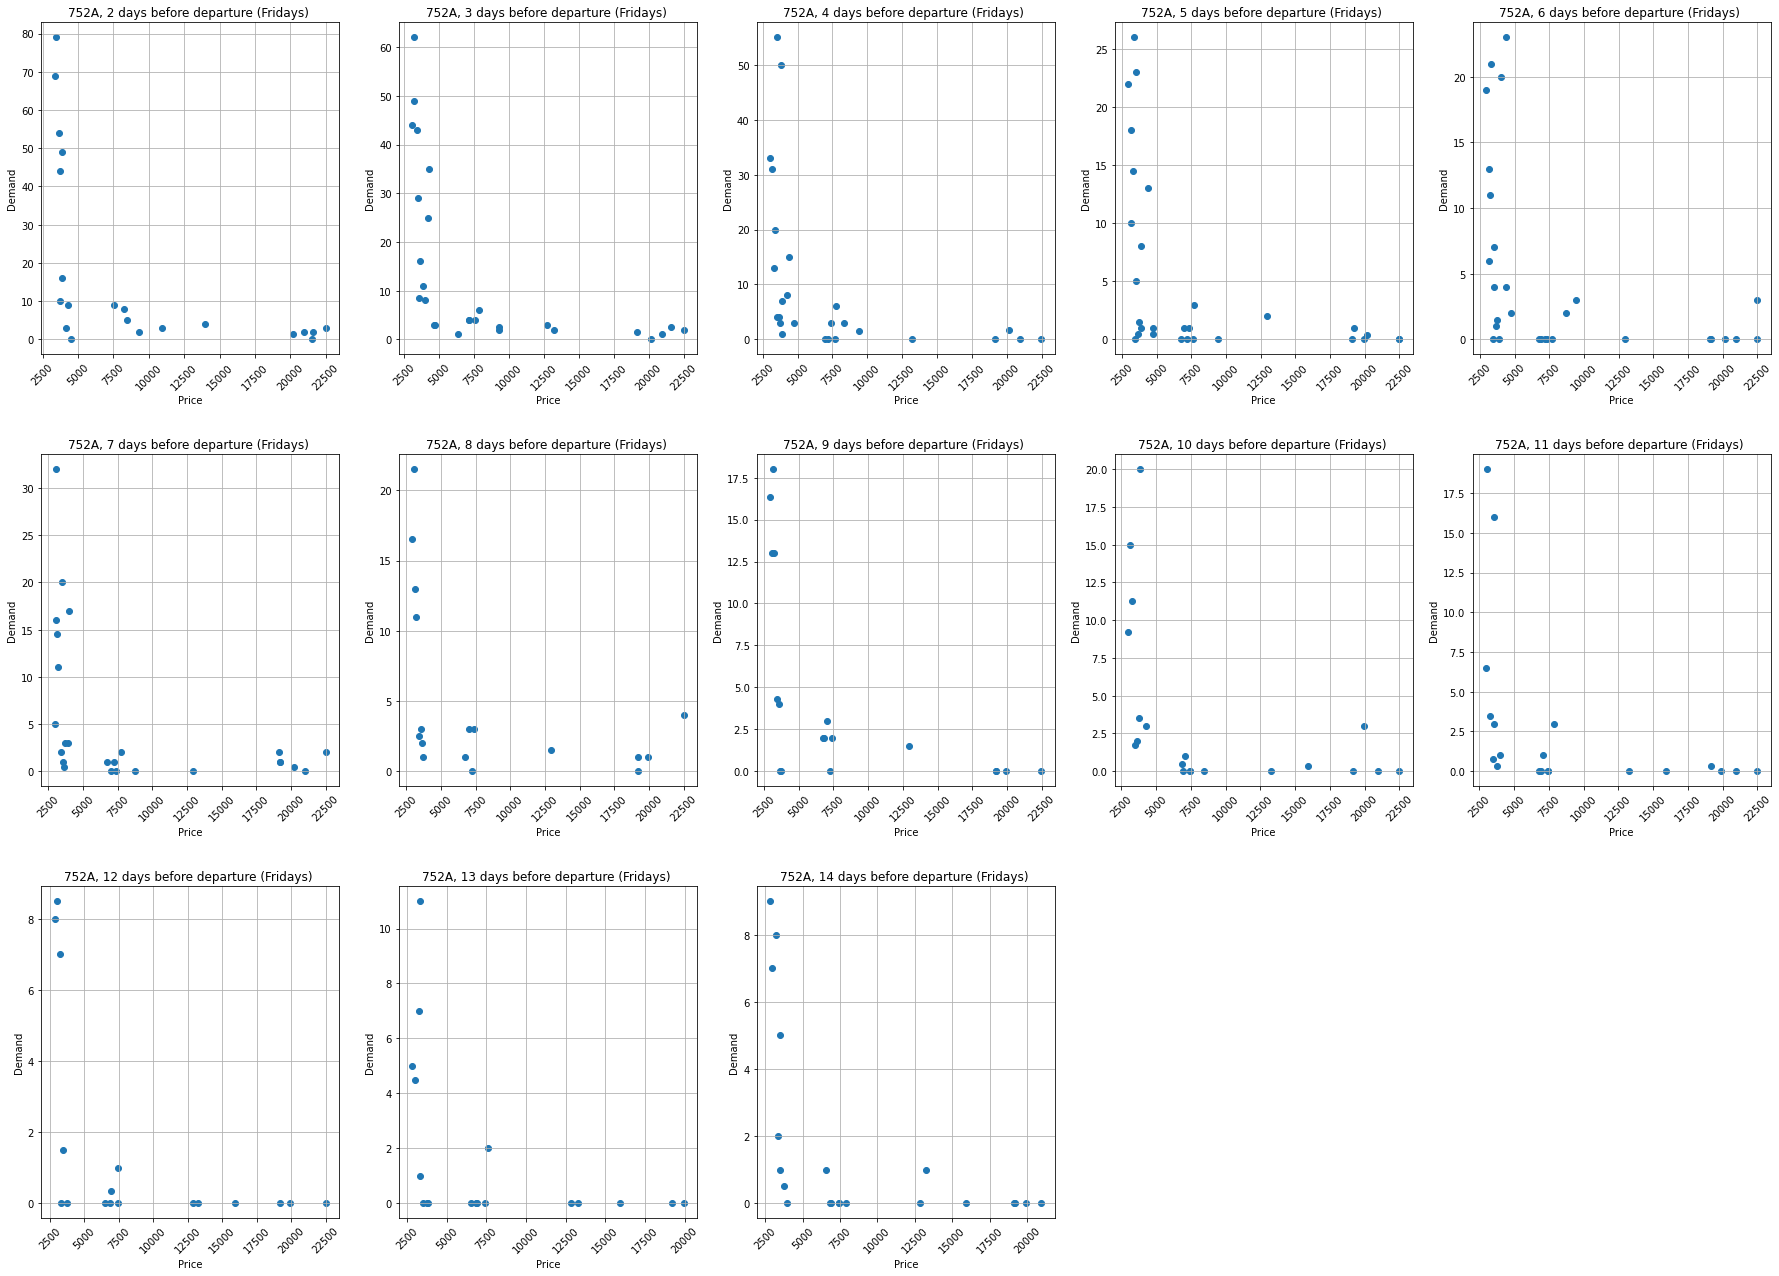

In [9]:
days=np.arange(2, 15)
train_name='752А'
wk_day='Friday'
folder='Experiments/Incremental Learning/Figure/'
plots.scatter_plot(mean_prices.loc[train_name].loc[wk_day], mean_demand.loc[train_name].loc[wk_day], days, train_name+' '+wk_day, 'processed PED', save=True, folder=folder)

In [10]:
mean_prices.to_csv('Experiments\Incremental Learning\Data\mean_prices.csv')
mean_demand.to_csv('Experiments\Incremental Learning\Data\mean_demand.csv')

## New data

In [28]:
folder=r'Datasets/new_data.zip'

new_data = pd.read_csv(folder, parse_dates=['date'], index_col=[0], encoding='utf-8')

new_data['weekday'] = new_data['date'].dt.weekday
new_data['day_name'] = new_data['date'].dt.day_name()

new_weekdays = new_data[['weekday', 'day_name']].drop_duplicates().sort_values(by='weekday').set_index('weekday')['day_name'].to_dict()
new_uniq_train_names=new_data['train'].unique()
new_uniq_train_num=new_data['num'].unique()
new_wk_days_mask=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

new_places = new_data.pivot_table(index=['num', 'day_name', 'date', 'class'], columns='days', values='places', aggfunc={'places': np.nanmean})

train_name='752А'
wk_day='Friday'

new_places.loc[train_name].loc[wk_day, :14].head()

days               1     2     3     4   5     6     7     8     9   10  11  \
date       class                                                              
2021-03-26 B1     3.0   1.0   NaN   NaN NaN   NaN   NaN   NaN   NaN NaN NaN   
           C1     NaN  15.0   NaN   NaN NaN   NaN   NaN   NaN   NaN NaN NaN   
2021-04-02 B1     NaN  12.0  12.0  14.0 NaN  14.0  14.0  14.0  14.0 NaN NaN   
           B2     NaN  23.0  27.0  34.0 NaN  36.0  38.0  40.0  41.0 NaN NaN   
           C1     NaN  33.0  33.0  39.0 NaN  42.0  41.0  42.0  42.0 NaN NaN   

days              12  13  14  
date       class              
2021-03-26 B1    NaN NaN NaN  
           C1    NaN NaN NaN  
2021-04-02 B1    NaN NaN NaN  
           B2    NaN NaN NaN  
           C1    NaN NaN NaN

### New Demand and prices

In [29]:
new_demand=(new_places-new_places.shift(axis=1))
new_demand[new_demand<0.]=np.nan
new_demand=new_demand.drop(columns=1, axis=0)
new_prices = new_data.pivot_table(index=['num', 'day_name', 'date', 'class'], columns='days', values='price')
new_prices_cons=new_prices.copy()
new_prices=new_prices.drop(columns=1, axis=0)
new_demand.loc[train_name].loc[wk_day, :14].head()

days              2    3    4   5   6    7    8    9   10  11  12  13  14
date       class                                                         
2021-03-26 B1    NaN  NaN  NaN NaN NaN  NaN  NaN  NaN NaN NaN NaN NaN NaN
           C1    NaN  NaN  NaN NaN NaN  NaN  NaN  NaN NaN NaN NaN NaN NaN
2021-04-02 B1    NaN  0.0  2.0 NaN NaN  0.0  0.0  0.0 NaN NaN NaN NaN NaN
           B2    NaN  4.0  7.0 NaN NaN  2.0  2.0  1.0 NaN NaN NaN NaN NaN
           C1    NaN  0.0  6.0 NaN NaN  NaN  1.0  0.0 NaN NaN NaN NaN NaN

Wall time: 1.51 s


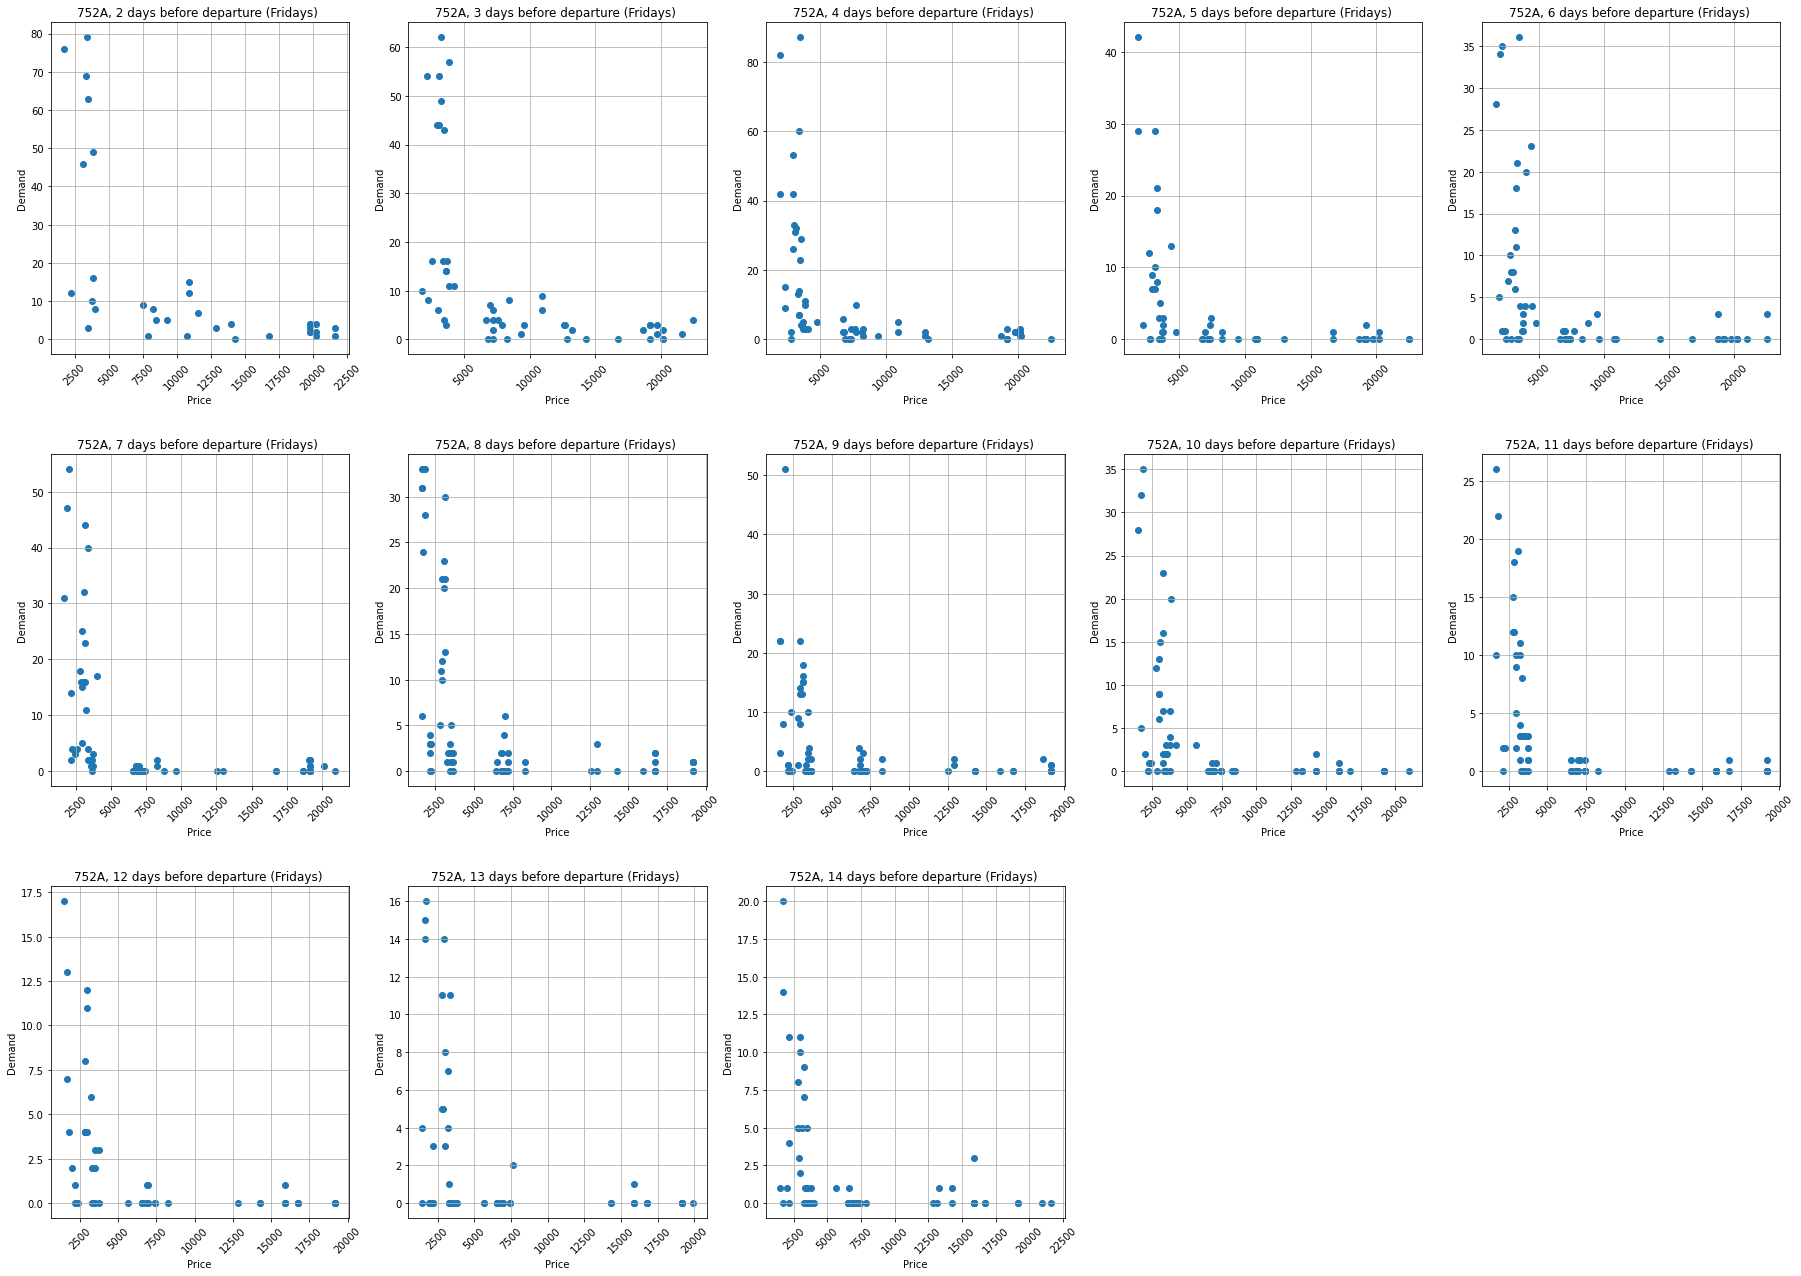

In [18]:
%%time
days=np.arange(2, 15)
folder='Experiments/Incremental Learning/Figure/'
plots.scatter_plot(new_prices.loc[train_name].loc[wk_day], new_demand.loc[train_name].loc[wk_day], days, train_name+' '+wk_day, 'new original PED', save=True, folder=folder)

In [31]:
new_prices.to_csv(r'Experiments\Incremental Learning\Data\new_prices.csv')
new_demand.to_csv(r'Experiments\Incremental Learning\Data\new_demand.csv')
new_places.to_csv(r'Experiments\Incremental Learning\Data\new_places.csv')
new_prices_cons.to_csv(r'Experiments\Incremental Learning\Data\new_prices_cons.csv')

### Removing duplicates and averaging

In [20]:
new_mean_prices=pd.DataFrame(data=np.nan, columns=new_prices.columns, index=new_prices.index, dtype="float")
new_mean_demand=pd.DataFrame(data=np.nan, columns=new_demand.columns, index=new_demand.index, dtype="float")
for num in new_uniq_train_num:
    for wk_day in new_wk_days_mask:
        for day in new_demand.columns:
            new_pr_dem_piv=processing.mean_duplicate_prices(new_prices.loc[num].loc[wk_day][day], 
                                             new_demand.loc[num].loc[wk_day][day])
            
            new_flat_pr_dem_piv=processing.flat_grouped_classes(new_pr_dem_piv)
            
            new_mean_prices.loc[num, wk_day].T.loc[day]=new_flat_pr_dem_piv.set_index(['date', 'class'])['prices']
            new_mean_demand.loc[num, wk_day].T.loc[day]=new_flat_pr_dem_piv.set_index(['date', 'class'])['demand']

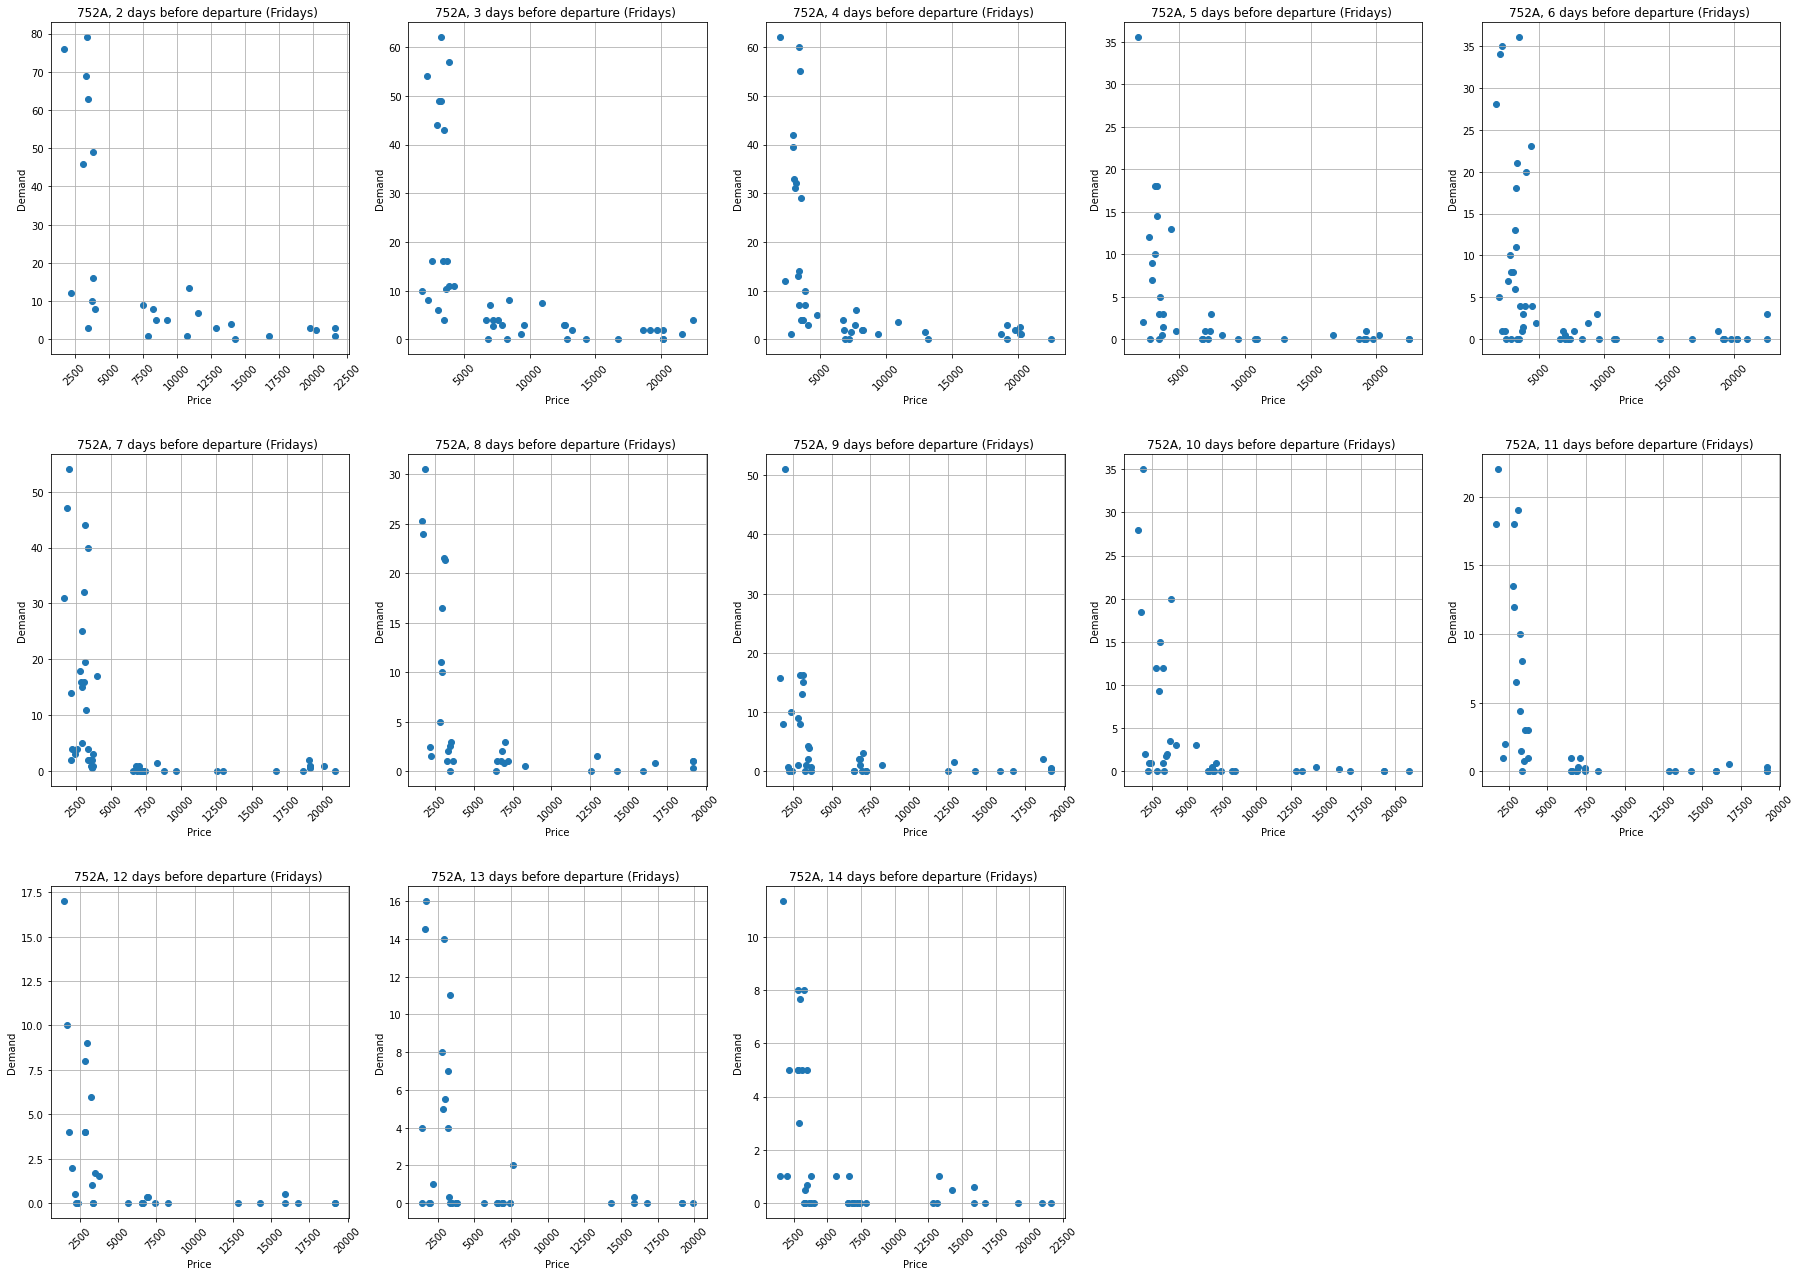

In [21]:
days=np.arange(2, 15)
train_name='752А'
wk_day='Friday'
folder='Experiments/Incremental Learning/Figure/'
plots.scatter_plot(new_mean_prices.loc[train_name].loc[wk_day], new_mean_demand.loc[train_name].loc[wk_day], days, train_name+' '+wk_day, 'new processed PED', save=True, folder=folder)

In [32]:
new_mean_prices.to_csv(r'Experiments\Incremental Learning\Data\new_mean_prices.csv')
new_mean_demand.to_csv(r'Experiments\Incremental Learning\Data\new_mean_demand.csv')